# Latent Dirichlet Allocation

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## Dirichlet distribution

In [3]:
dir_f = np.random.dirichlet

A = np.array([
    [1, 1, 1],
    [.1, .1, .1],
    [60, 60, 60],
    [.2, 1, 15],
])

distributions = [dir_f(alpha=x, size=1000) for x in A]

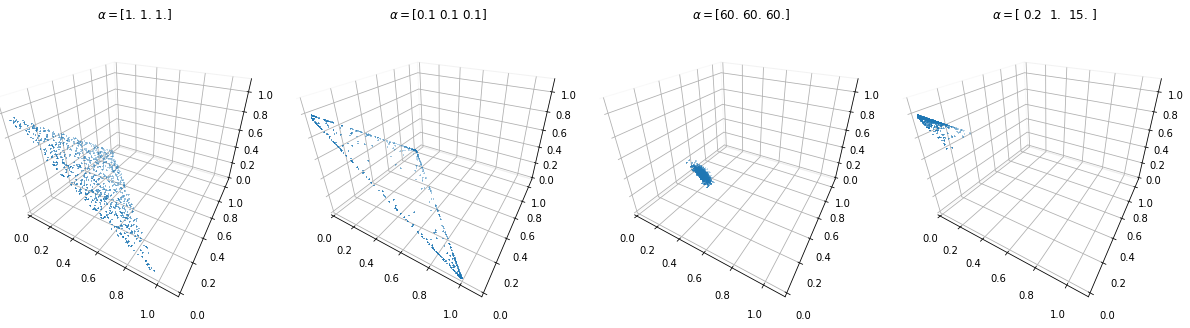

In [4]:
fig, ax = plt.subplots(ncols=4, subplot_kw={'projection': '3d'}, figsize=(17, 4))
for i, d in enumerate(distributions):
    ax[i].xaxis.pane.fill = False
    ax[i].yaxis.pane.fill = False
    ax[i].zaxis.pane.fill = False
    ax[i].set_proj_type('persp', focal_length=0.18)
    ax[i].scatter(d[:,0], d[:,1], d[:,2], marker='+', s=.5)
    ax[i].set_title(r"$\alpha = ${}".format(str(A[i])))
    ax[i].set_xlim3d(left=0, right=1.1)
    ax[i].set_ylim3d(bottom=0, top=1.1)
    ax[i].set_zlim3d(bottom=0, top=1.1)
plt.tight_layout()
plt.savefig('../imgs/dirichlet.png')
plt.show()

## Generative process
In order to generate texts using LDA, we need to fix the number $k$ of topics and:

- $\phi^{(k)} \sim Dir(\beta)$
- $N = Poisson(\zeta)$
- $\theta_d \sim Dir(\alpha)$

In this example, we derive $\phi$ for a bunch of documents.

In [5]:
from collections import defaultdict

In [6]:
documents = [
    ['napoleon', 'bonaparte', 'leader', 'battle'],
    ['napoleon', 'leader', 'battle', 'napoleon', 'waterloo'],
    ['leader', 'battle', 'bonaparte', 'waterloo'],
    ['city', 'united states', 'county'],
    ['napoleon', 'county'],
    ['missouri', 'kansas', 'city'],
    ['missouri', 'united states', 'city'],
    ['county', 'napoleon', 'leader', 'bonaparte', 'waterloo']
]
topics_annotations = [['history'], ['history'], ['history'], ['geography'], ['history', 'geography'], 
                      ['geography'], ['geography'], ['history', 'geography']]

In [7]:
word_counts = defaultdict(lambda: defaultdict(lambda: 0))
for i, doc in enumerate(documents):
    for annotation in topics_annotations[i]:
        for word in doc:
            word_counts[word][annotation] += 1
wcount = pd.DataFrame(word_counts).fillna(0.001)
vocabulary = wcount.columns

In [8]:
wcount

,napoleon,bonaparte,leader,battle,waterloo,city,united states,county,missouri,kansas
history,5,3,4,3.000,3,0.001,0.001,2,0.001,0.001
geography,2,1,1,0.001,1,3.000,2.000,3,2.000,1.000


In [9]:
phi = pd.DataFrame(
    np.array([np.random.dirichlet(wcount.loc['history']), 
              np.random.dirichlet(wcount.loc['geography'])]), index=['history', 'geography'], columns=vocabulary)

In [10]:
phi

,napoleon,bonaparte,leader,battle,waterloo,city,united states,county,missouri,kansas
history,0.241737,0.203880,0.186191,1.622600e-01,0.160269,0.000000,4.325312e-66,0.045664,0.000000,3.500896e-145
geography,0.070376,0.045806,0.048013,8.219747e-75,0.012378,0.296645,1.169870e-01,0.204176,0.180988,2.462966e-02


### Documents generation

In [13]:
M = 10 # number of documents in the generated corpus
alpha = [.3, .2] # priors for the expected proportion of docs per topics
zeta = 8 # seed for the lenght of docs
topics = ['history', 'geography']

new_documents = []
for i in range(M):
    theta_d = np.random.dirichlet(alpha)
    N = np.random.poisson(zeta)
    new_document = []
    for w in range(N):
        selected_topic = np.random.choice(topics, p=theta_d)
        phi_z = phi.loc[selected_topic]
        word = np.random.choice(vocabulary, p=phi_z)
        new_document.append(word)
    new_documents.append(new_document)

In [14]:
for i, doc in enumerate(new_documents):
    print('DOC {}\t'.format(i+1), ", ".join(doc))

DOC 1	 county, kansas, county, city, city, county
DOC 2	 missouri, leader, city, missouri, missouri
DOC 3	 napoleon, bonaparte, napoleon, waterloo, battle, county, bonaparte, county
DOC 4	 city, city, napoleon, city, city, missouri, missouri, bonaparte, waterloo, missouri, missouri, county, city
DOC 5	 napoleon, leader, leader, bonaparte, bonaparte, bonaparte
DOC 6	 napoleon, waterloo, bonaparte, waterloo, waterloo, napoleon, bonaparte, napoleon, bonaparte
DOC 7	 napoleon, bonaparte, missouri, county, county, city, napoleon, county
DOC 8	 waterloo, bonaparte, napoleon
DOC 9	 city, missouri, united states, napoleon, bonaparte, city, united states
DOC 10	 united states, county, missouri, city, napoleon, united states, united states, city


# Posterior inference with Gibbs sampling

## Init counters
We first set the number of topics $K$ and we randomly initialize some counters:

- $n_{d,k}$ number of words of the document $d$ assigned to $k$
- $n_{k,w}$ number of times (instances of) word $w$ is assigned to $k$
- $z$ array of assignments to topics for each of the words instances

In [15]:
from IPython.display import display

In [16]:
K = 2
N = sum(len(x) for x in documents)
alpha = np.array([.1]*K)
beta = np.array([.1]*len(vocabulary))

In [17]:
def init_gibbs():
    z = np.zeros(N)
    ndk = np.zeros((len(documents), K))
    nkw = np.zeros((K, len(vocabulary)))

    word_index = 0
    for i, doc in enumerate(documents):
        for word in doc:
            topic = np.random.choice(range(K))
            z[word_index] = topic
            ndk[i,topic] += 1
            nkw[topic, list(vocabulary).index(word)] += 1
            word_index += 1
    return z, ndk, nkw

def show(lda):
    z, ndk, nkw = lda
    Z = pd.DataFrame(z).T
    Z.columns = ["{}_{}".format(w, i) for i, w in enumerate([x for y in documents for x in y])]
    Ndk = pd.DataFrame(ndk)
    Nkw = pd.DataFrame(nkw, columns=vocabulary)
    display(Z)
    display(Ndk.T)
    display(Nkw)

In [18]:
lda_0 = init_gibbs()
show(lda_0)

,napoleon_0,bonaparte_1,leader_2,battle_3,napoleon_4,leader_5,battle_6,napoleon_7,waterloo_8,leader_9,...,kansas_19,city_20,missouri_21,united states_22,city_23,county_24,napoleon_25,leader_26,bonaparte_27,waterloo_28
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0


,0,1,2,3,4,5,6,7
0,3.0,4.0,1.0,2.0,1.0,1.0,1.0,2.0
1,1.0,1.0,3.0,1.0,1.0,2.0,2.0,3.0


,napoleon,bonaparte,leader,battle,waterloo,city,united states,county,missouri,kansas
0,4.0,0.0,2.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0
1,1.0,3.0,2.0,1.0,1.0,2.0,0.0,1.0,2.0,1.0


## Inference
```
begin
    for iteration in iterations:
        for document in documents:
            for word in document:
                topic = Z[word]
                reduce counters for word and corresponding document
                for topic in topics:
                    get P(topic) by the counters
                new_topic = sample from P(topic)
                Z[word] = new_topic
                update counters
end
```

In [19]:
import copy

In [27]:
def theta(ndk, alpha, d_i, k_i):
    return (ndk[d_i, k_i] + alpha[k_i]) / (np.sum(ndk[d_i,:]) + sum(alpha))

def phi(nkw, beta, w_i, k_i):
    return (nkw[k_i, w_i] + beta[w_i]) / (np.sum(nkw[k_i,:] + sum(beta)))

def topic_distribution(doc_i, word_i, lda):
    z, ndk, nkw = lda
    p_z = np.zeros(K)
    for k_i in range(K):
        p_z[k_i] = theta(ndk, alpha, doc_i, k_i) * phi(nkw, beta, word_i, k_i)
    p_z = p_z / np.sum(p_z)

def gibbs(documents, vocabulary, lda, alpha, beta, iterations=10):
    voc = list(vocabulary)
    run = list(range(iterations))
    z, ndk, nkw = lda
    history = [(copy.deepcopy(z), copy.deepcopy(ndk), copy.deepcopy(nkw))]
    for it in tqdm(run):
        w_i = 0
        for doc_i, doc in enumerate(documents):
            for word in doc:
                current_topic = int(z[w_i])
                # Sample from p_z
                p_z = topic_distribution(doc_i, voc.index(word), (z, ndk, nkw))
                new_topic = np.random.choice(range(K), p=p_z)
                # Remove current assignment
                ndk[doc_i, current_topic] -= 1
                nkw[current_topic, voc.index(word)] -= 1
                # Update counters
                z[w_i] = new_topic
                ndk[doc_i, new_topic] += 1
                nkw[new_topic, voc.index(word)] += 1
                w_i += 1
        history.append((copy.deepcopy(z), copy.deepcopy(ndk), copy.deepcopy(nkw)))
    return history

In [28]:
lda_h = gibbs(documents, vocabulary, lda_0, alpha, beta, iterations=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [29]:
show(lda_h[-1])

,napoleon_0,bonaparte_1,leader_2,battle_3,napoleon_4,leader_5,battle_6,napoleon_7,waterloo_8,leader_9,...,kansas_19,city_20,missouri_21,united states_22,city_23,county_24,napoleon_25,leader_26,bonaparte_27,waterloo_28
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


,0,1,2,3,4,5,6,7
0,2.0,4.0,2.0,1.0,1.0,1.0,1.0,3.0
1,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0


,napoleon,bonaparte,leader,battle,waterloo,city,united states,county,missouri,kansas
0,4.0,1.0,3.0,2.0,1.0,0.0,0.0,2.0,2.0,0.0
1,1.0,2.0,1.0,1.0,2.0,3.0,2.0,1.0,0.0,1.0


## System dinamics

In [30]:
from IPython.display import clear_output
import time

In [31]:
for lda_i in lda_h:
    cmd = input()
    if cmd == 'quit':
        break
    show(lda_i)
    clear_output(wait=True)

quit


In [32]:
hist_terms = ['napoleon', 'bonaparte', 'leader']
geo_terms = ['city', 'county', 'united states']
h_indexes = [list(vocabulary).index(x) for x in hist_terms]
g_indexes = [list(vocabulary).index(x) for x in geo_terms]

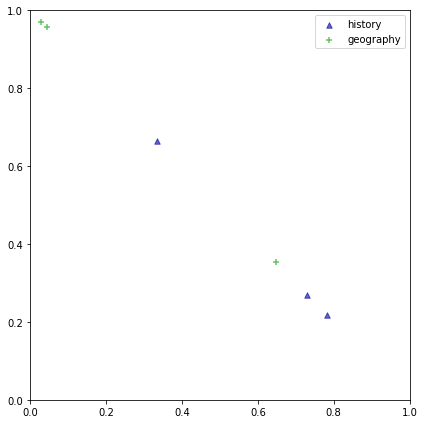

In [33]:
every = range(0, len(lda_h), 100)

for experiment in every:
    z, ndk, nkw = lda_h[experiment]
    H = []
    for h in h_indexes:
        p = np.array([phi(nkw, beta, h, t) for t in range(K)])
        p = p / p.sum()
        H.append(p)
    H = np.array(H)
    G = []
    for g in g_indexes:
        p = np.array([phi(nkw, beta, g, t) for t in range(K)])
        p = p / p.sum()
        G.append(p)
    G = np.array(G)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(H[:,0], H[:,1], label='history', c='#000099', alpha=.6, marker='^', s=30)
    ax.scatter(G[:,0], G[:,1], label='geography', c='#009900', alpha=.6, marker='+', s=30)
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    ax.legend()
    plt.tight_layout()
    plt.show()
    clear_output(wait=True)